In [1]:
import os
import time
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
from torch.nn import functional as F
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    roc_curve, auc, confusion_matrix, matthews_corrcoef
)
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the dataset for DeepFake detection
class DeepFakeDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        image = Image.open(img_name)

        if 'real' in img_name:
            label = 0
        elif 'deepfake' in img_name:
            label = 1
        else:
            raise ValueError(f'Unknown label in file name: {img_name}')

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Function to filter and randomly select images
def select_images(root_dir, label, num_images):
    image_list = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if label in img]
    selected_images = random.sample(image_list, num_images)
    return selected_images

In [4]:
# Coordinate Attention block
class CoordinateAttention(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=32):
        super(CoordinateAttention, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        mip = max(8, in_channels // reduction)
        self.conv1 = nn.Conv2d(in_channels, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.relu = nn.ReLU(inplace=True)
        self.conv_h = nn.Conv2d(mip, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        identity = x
        n, c, h, w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)
        y = torch.cat([x_h, x_w], dim=2)
        y = self.relu(self.bn1(self.conv1(y)))
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)
        a_h = torch.sigmoid(self.conv_h(x_h))
        a_w = torch.sigmoid(self.conv_w(x_w))
        out = identity * a_h * a_w
        return out

In [5]:
# Custom DenseNet121 with Coordinate Attention
class CustomDenseNet121(nn.Module):
    def __init__(self):
        super(CustomDenseNet121, self).__init__()
        densenet = models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')
        self.features = nn.Sequential(
            densenet.features.conv0,
            densenet.features.norm0,
            densenet.features.relu0,
            densenet.features.pool0,
            densenet.features.denseblock1,
            densenet.features.transition1,
            CoordinateAttention(in_channels=128, out_channels=128),
        )
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 16)
        )

    def forward(self, x):
        x = self.features(x)
        # print('shape before fc : ', x.shape)
        x = self.fc(x)
        return x

In [6]:
# Main DeepFake detection model
class DeepFakeDetectionModel(nn.Module):
    def __init__(self):
        super(DeepFakeDetectionModel, self).__init__()
        self.branch1 = CustomDenseNet121()
        self.branch2 = CustomDenseNet121()
        self.branch2.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.branch3 = CustomDenseNet121()
        self.fc_final = nn.Linear(48, 2)

    def forward(self, x):
        x_edge = self.apply_canny(x)
        x_texture = self.extract_texture(x)

        out1 = self.branch1(x)
        out2 = self.branch2(x_edge)
        out3 = self.branch3(x_texture)

        out = torch.cat([out1, out2, out3], dim=1)
        out = self.fc_final(out)

        return out

    def apply_canny(self, x):
        # Convert to numpy, apply Canny edge detection, and convert back to tensor
        x = x.permute(0, 2, 3, 1).cpu().numpy()  # BxCxHxW -> BxHxWxC
        x_edge = []
        for img in x:
            edge = cv2.Canny((img * 255).astype('uint8'), 100, 200)
            x_edge.append(edge)
          # Convert list to numpy array
        x_edge = torch.tensor(np.array(x_edge))
        x_edge = x_edge.unsqueeze(1).float()
        
        # print('shape of edge image : ', x_edge.shape)
        # print('type of edge matrix ', type(x_edge))
        x_edge=x_edge.to(device)
        return x_edge  # Move to GPU

    def extract_texture(self, x):
        # Use Laplacian for texture extraction
        x = x.permute(0, 2, 3, 1).cpu().numpy()
        x_texture = []
        for img in x:
            texture = cv2.Laplacian((img * 255).astype('uint8'), cv2.CV_64F)
            # print('shape in texture : ', texture.shape)
            x_texture.append(texture)
         # Convert list to numpy array
        tex_array = np.array(x_texture)
        # print('shape ...... ', tex_array.shape)
        tex_array = np.transpose(tex_array, (0, 3, 1, 2))
        #print('updated shape : ', tex_array.shape)
        x_texture = torch.tensor(tex_array).float()
        # x_texture = x_texture.unsqueeze(1).float()
        # x_texture = torch.tensor(x_texture).unsqueeze(1).float() / 255.0
        x_texture= x_texture.to(device)
        return x_texture

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 154MB/s] 


Total number of parameters: 1143642
Epoch 1/3
----------
Train Loss: 0.6189 Acc: 0.6471
Val Loss: 1.6100 Acc: 0.5637
Epoch 2/3
----------
Train Loss: 0.5648 Acc: 0.6999
Val Loss: 0.6620 Acc: 0.6400
Epoch 3/3
----------
Train Loss: 0.5377 Acc: 0.7222
Val Loss: 0.5873 Acc: 0.7016
Total training time: 1936.57 seconds
Model saved successfully.


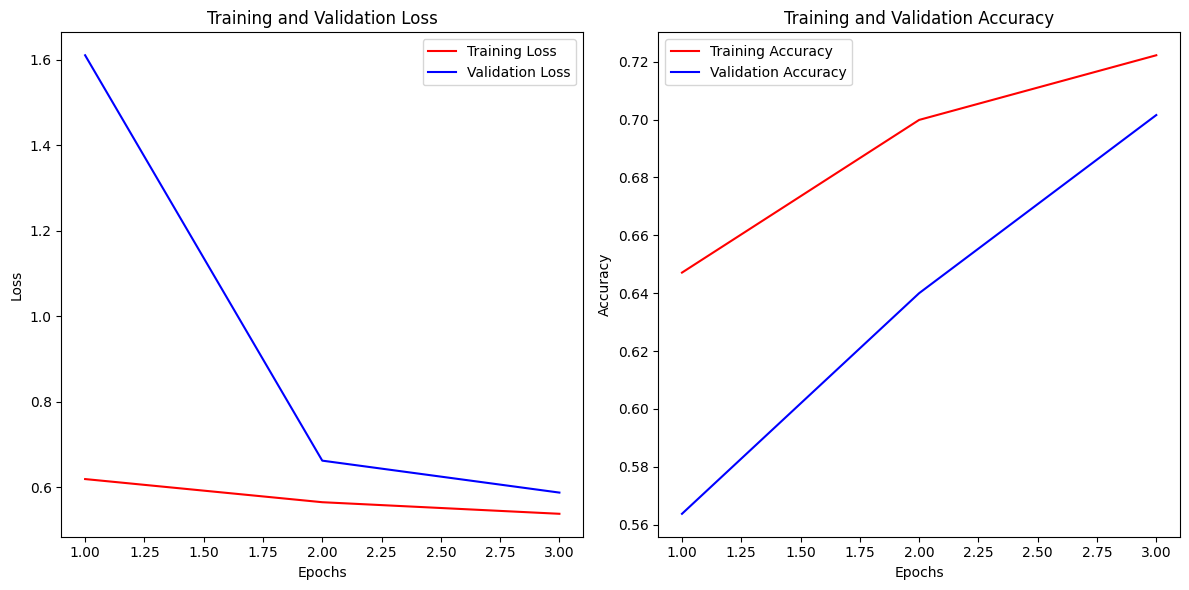

Accuracy: 0.7122
Precision: 0.7226
Recall: 0.6887
F1 Score: 0.7053
ROC AUC Score: 0.7917
Matthews Correlation Coefficient (MCC): 0.4248


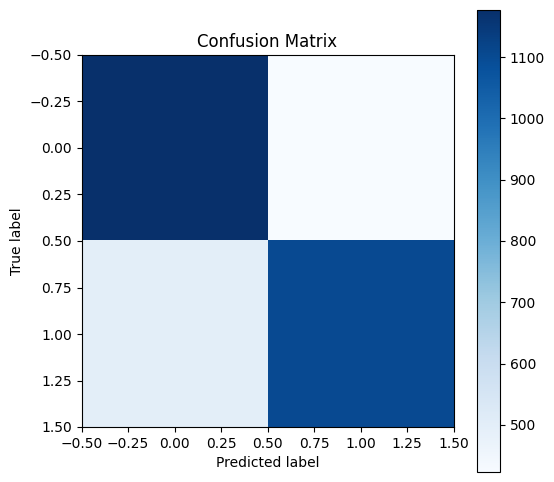

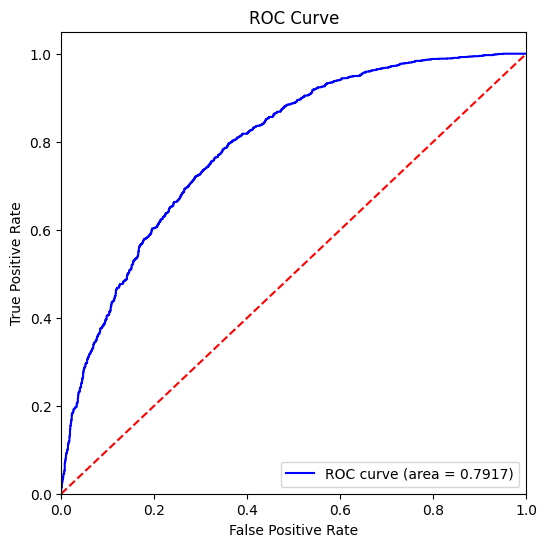

In [7]:
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    root_dir = '/kaggle/input/final-data/final_dataset'
    num_samples = 16000  

    # Select 16000 'real' and 16000 'deepfake' images
    real_images = select_images(root_dir, 'real', num_samples)
    deepfake_images = select_images(root_dir, 'deepfake', num_samples)

    selected_images = real_images + deepfake_images
    random.shuffle(selected_images)

    # Define transformations
    data_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ])

    # Create a dataset
    dataset = DeepFakeDataset(image_list=selected_images, transform=data_transforms)

    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    model = DeepFakeDetectionModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params}")

    # Training loop
    def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
        best_acc = 0.0
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            model.train()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset)
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())

            print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Validation phase
            model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            scheduler.step()
            epoch_loss = running_loss / len(val_loader.dataset)
            epoch_acc = running_corrects.double() / len(val_loader.dataset)
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        total_time = time.time() - start_time
        print(f'Total training time: {total_time:.2f} seconds')

        # Save the model after training
        torch.save(model.state_dict(), 'deepfake_detection_model.pth')
        print("Model saved successfully.")

        return train_losses, val_losses, train_accuracies, val_accuracies

    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, criterion, optimizer, train_loader, val_loader, num_epochs=3
    )

    def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 6))
    
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, 'r', label='Training Loss')
        plt.plot(epochs, val_losses, 'b', label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Subplot for accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
        plt.plot(epochs, val_accuracies, 'b', label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    
    def evaluate_model(model, test_loader):
        model.eval()
        all_labels = []
        all_preds = []
        all_probs = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for ROC AUC

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        roc_auc = roc_auc_score(all_labels, all_probs)
        mcc = matthews_corrcoef(all_labels, all_preds)

        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'ROC AUC Score: {roc_auc:.4f}')
        print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, cmap='Blues', interpolation='nearest')
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    evaluate_model(model, test_loader)